<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

Mounted at /content/drive


In [7]:
# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'

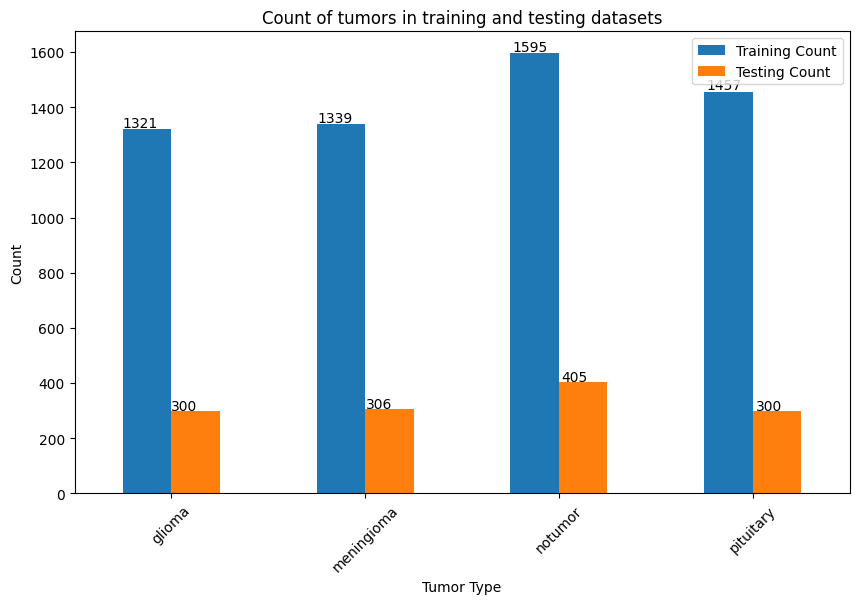

In [8]:
def get_images(directory_path):
    count_image_dict = {}
    img_paths = []
    img_labels = []
    for class_img_dir in os.listdir(directory_path):
        class_img_path = os.path.join(directory_path, class_img_dir)
        if os.path.isdir(class_img_path):
            count_image_dict[class_img_dir] = len(os.listdir(class_img_path))
            for img_name in os.listdir(class_img_path):
                img_paths.append(os.path.join(class_img_path, img_name))
                img_labels.append(class_img_dir)
    return count_image_dict, img_paths, img_labels

training_count, training_img_paths, training_label = get_images(training_path)
testing_count, testing_image_paths, testing_label = get_images(testing_path)

training_data_df = pd.DataFrame(list(training_count.items()), columns=['Tumor Type', 'Training Count'])
testing_data_df = pd.DataFrame(list(testing_count.items()), columns=['Tumor Type', 'Testing Count'])

combined_data_df = pd.merge(training_data_df, testing_data_df, on='Tumor Type')
combined_data_df.set_index('Tumor Type', inplace=True)

axes = combined_data_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of tumors in training and testing datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in axes.patches:
    axes.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [9]:
unique_names = list(set(training_label))
print('unique names: ', unique_names)
class_naming = {label: idx for idx, label in enumerate(unique_names)}
print('class naming: ', class_naming)

training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

unique names:  ['notumor', 'glioma', 'meningioma', 'pituitary']
class naming:  {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}


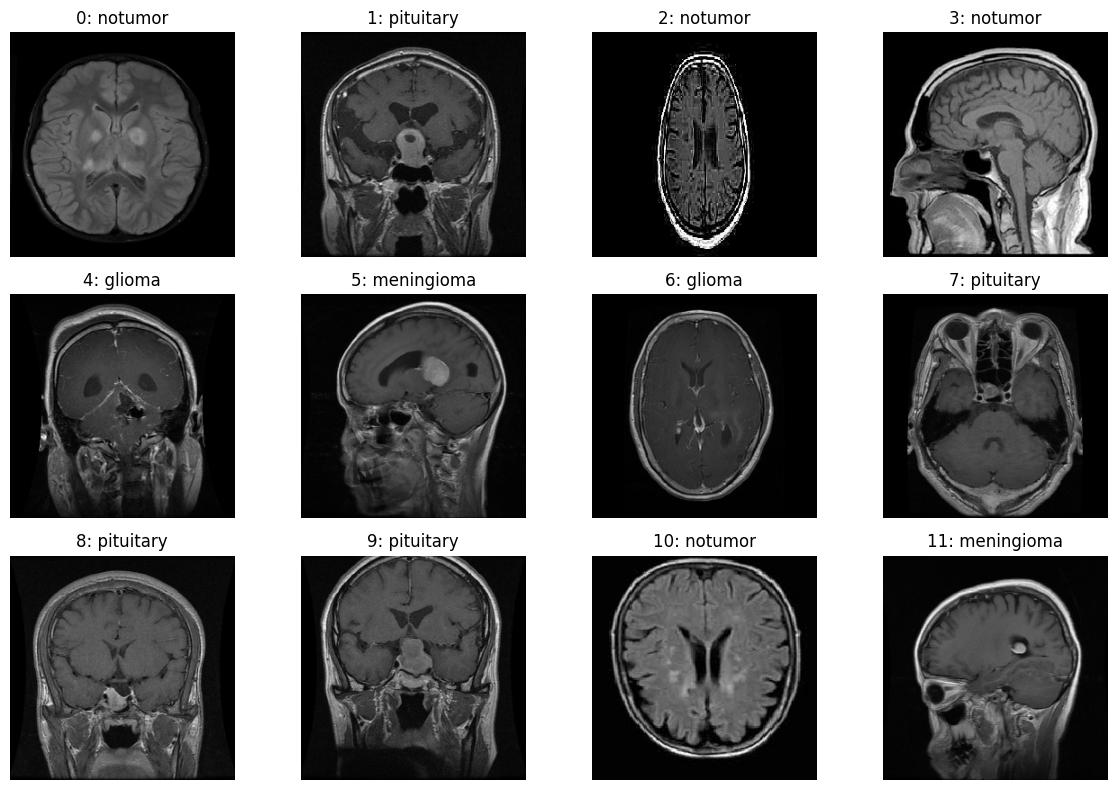

In [10]:
def show_img(path, label_indx, class_naming, index_list=range(10), img_size=250, figsize=(12, 8)):
    num_img = len(index_list)
    rows = (num_img + 3) // 4
    indx_to_class = {v: k for k, v in class_naming.items()}
    _, axes = plt.subplots(nrows=rows, ncols=4, figsize=figsize)
    axes = axes.flatten()

    for i, index in enumerate(index_list):
        if i >= num_img or index >= len(path):
            axes[i].axis('off')
            continue
        image = load_img(path[index], target_size=(img_size, img_size))
        axes[i].imshow(image)
        class_name = indx_to_class[label_indx[index]]
        axes[i].set_title(f'{index}: {class_name}')
        axes[i].axis('off')

    for j in range(num_img, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

combined = list(zip(training_img_paths, training_label_indx))
random.shuffle(combined)
training_img_paths, training_label_indx = zip(*combined)
show_img(training_img_paths, training_label_indx, class_naming, index_list=range(12))

In [11]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

In [12]:
image_dim = (250, 250)
batch_size = 32

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_dim)
    return image, label

def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

training_img_paths = np.array(training_img_paths)
training_label_indx = np.array(training_label_indx)
testing_img_paths = np.array(testing_image_paths)
testing_label_indx = np.array(testing_label_indx)

train_ds = tf.data.Dataset.from_tensor_slices((training_img_paths, training_label_indx))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_img_paths, testing_label_indx))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_preprocessed = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

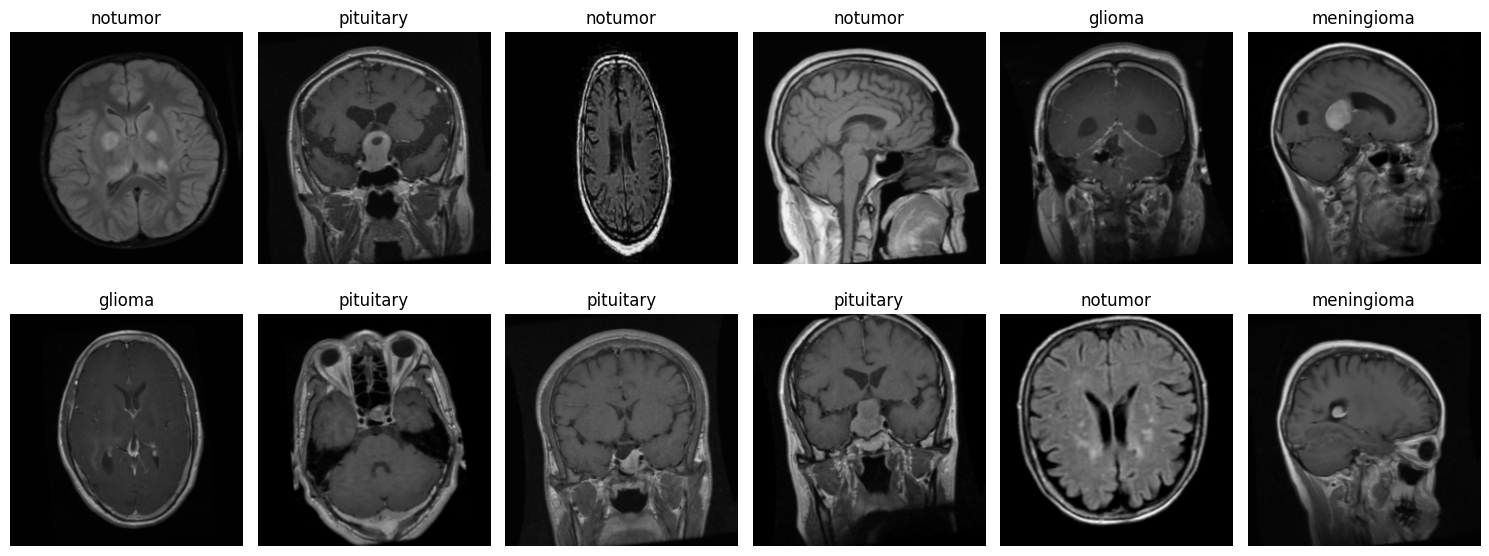

In [13]:
def plot_augmented_images(dataset, shape, class_naming, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    indx_to_class = {v: k for k, v in class_naming.items()}
    for images, label in dataset.take(1):
        for i in range(shape[0] * shape[1]):
            axes = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze())
            plt.title(indx_to_class[label.numpy()[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_naming=class_naming)

In [14]:
num_classes = len(class_naming.keys())
image_shape = (image_dim[0], image_dim[1], 3)
epochs = 50

inv_class_naming = {v: k for k, v in class_naming.items()}
print(f'Inverse class mappings: {inv_class_naming}')

print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
# print(f'Batch size: {batch_size}')


Inverse class mappings: {0: 'notumor', 1: 'glioma', 2: 'meningioma', 3: 'pituitary'}
Number of Classes: 4
Image shape: (250, 250, 3)
Epochs: 50


In [15]:
def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

In [17]:
input_shape = (image_dim[0], image_dim[1], 3)
model = create_cnn_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

In [19]:
thresholds = [0.96, 0.99, 0.9935]
model_file = 'cnn_model.keras'
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint(model_file, monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

In [20]:
# Train the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)

Epoch 1/50
 68/179 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.5447 - loss: 1.2126

KeyboardInterrupt: 

In [16]:
# Load the best model
cnn_model = load_model('cnn_model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9945 - loss: 0.0463
Test accuracy: 99.3135%


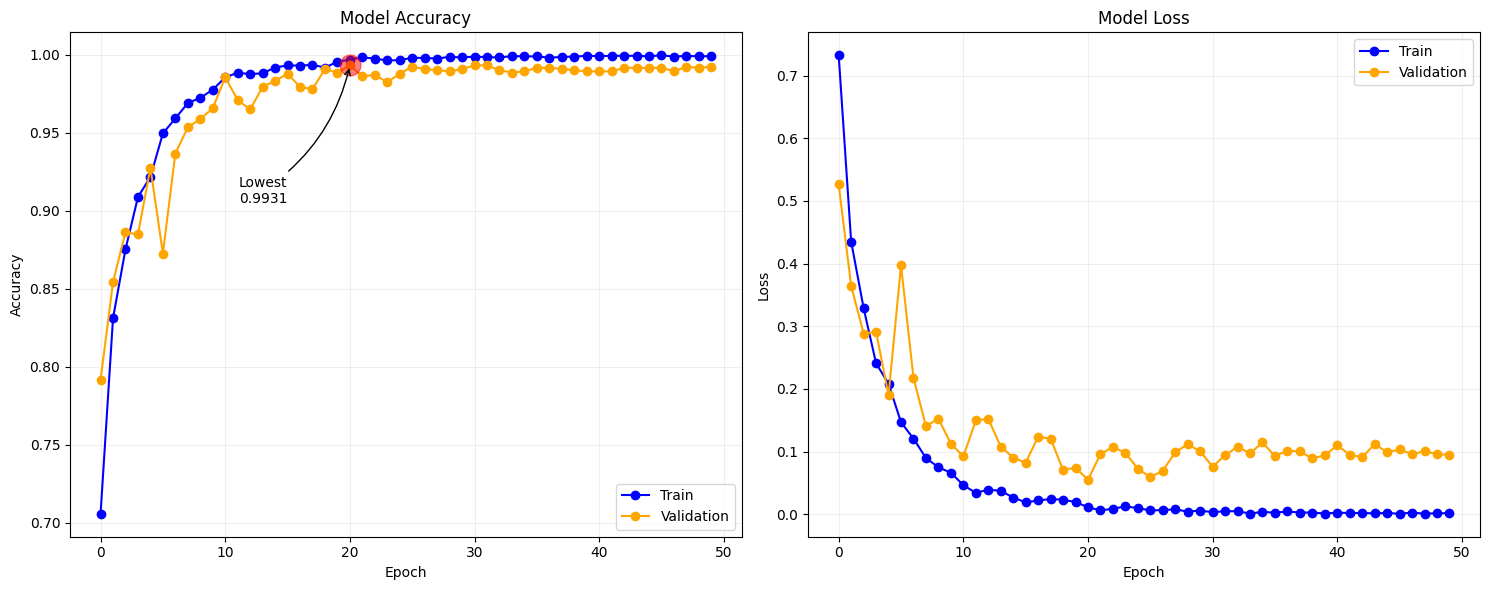

In [17]:
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
axes[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
axes[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [15]:
# Using test data for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [16]:
def plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_naming
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_naming)):
            class_name = list(class_naming.keys())[i]
            print(f"Class: {class_name}")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"Overall Accuracy: {accuracy:.4f}")

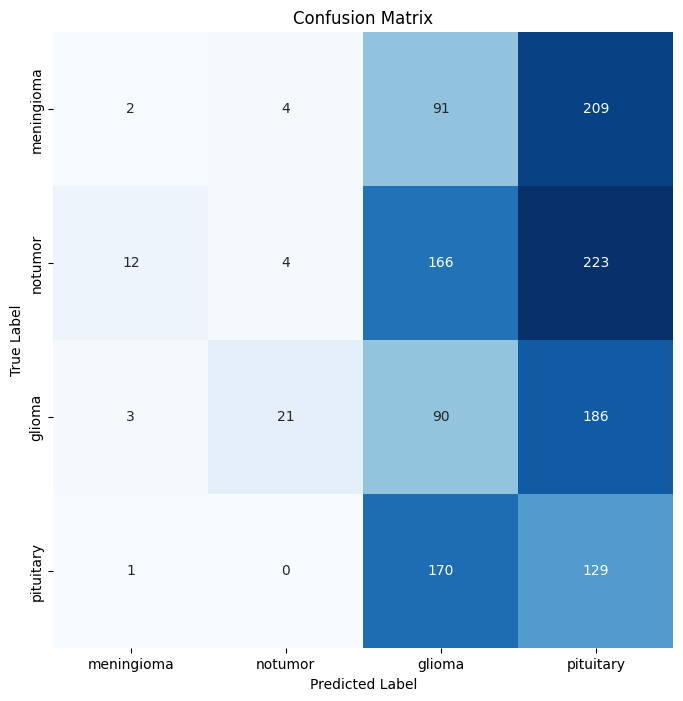

Class-wise metrics:
Class: meningioma
Precision: 0.1111
Recall: 0.0065
F1-Score: 0.0123

Class: notumor
Precision: 0.1379
Recall: 0.0099
F1-Score: 0.0184

Class: glioma
Precision: 0.1741
Recall: 0.3000
F1-Score: 0.2203

Class: pituitary
Precision: 0.1727
Recall: 0.4300
F1-Score: 0.2464

Overall Accuracy: 0.1716


In [17]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_naming,
                      metrics=True)

In [18]:
def plot_sample_predictions(model, folder_path, indx_to_class, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    image_files = []
    true_labels = []
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for image_file in os.listdir(subfolder_path):
            if image_file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_files.append(os.path.join(subfolder_path, image_file))
                true_labels.append(subfolder)

    num_samples = len(image_files)
    if num_samples == 0:
        print("No images found in the specified folder.")
        return

    num_cols = int(np.sqrt(num_samples))
    rows = (num_samples // num_cols) + (num_samples % num_cols > 0)

    for i, image_path in enumerate(image_files):
        img = Image.open(image_path).resize((250, 250))  # Resize to 250x250
        img_array = np.array(img) / 255.0  # Normalize the image
        img_batch = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        predicted_class = indx_to_class[predicted_label]

        true_class = true_labels[i]

        plt.subplot(rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPredicted: {predicted_class}", color='green')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [19]:
# Plottinng samples with predictions
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
plot_sample_predictions(cnn_model, prediction_folder, inv_class_naming, figsize=(13, 12))

NameError: name 'cnn_model' is not defined

In [20]:
def plot_misclassified_samples(model, dataset, indx_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(indx_to_class[true_class_index])
            misclassified_predictions.append(indx_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

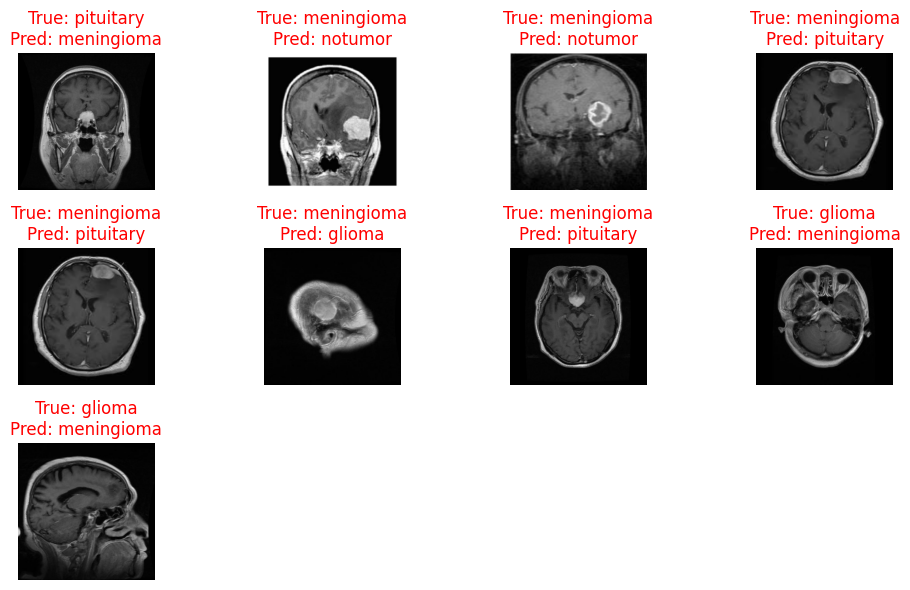

In [25]:
plot_misclassified_samples(model=cnn_model,
                           dataset=test_ds_preprocessed,
                           indx_to_class=inv_class_naming,
                           figsize=(10, 6))

**Model: CNN-VGG16**

In [21]:
# Create CNN-VGG16 model
def create_cnn_vgg16_model(input_shape, num_classes):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    # Freeze all the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers of the base model
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


In [25]:
# input_shape = (image_dim[0], image_dim[1], 3)
epochs = 10
vgg16_model = create_cnn_vgg16_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

thresholds = [0.96, 0.99, 0.9935]
vgg16_model_file = 'cnn_vgg16_model.keras'
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint(vgg16_model_file, monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)
# print('model_mc ', model_mc)

In [26]:
# Train the model
vgg16_history = vgg16_model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - accuracy: 0.7497 - loss: 0.6187 - val_accuracy: 0.8818 - val_loss: 0.3258 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9150 - loss: 0.2272 - val_accuracy: 0.9497 - val_loss: 0.1437 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.9529 - loss: 0.1209 - val_accuracy: 0.9535 - val_loss: 0.1321 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - accuracy: 0.9646 - loss: 0.0947 - val_accuracy: 0.9611 - val_loss: 0.1076 - learning_rate: 1.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 200ms/step - accuracy: 0.9799 - loss: 0.0573 - val_accuracy: 0.9725 - val_loss: 0.0746 - learning_rate: 7.5000e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.9855 - loss: 0.0406 - val_accuracy: 0.9809 - val_loss: 0.0470 - learning_rate: 7.5000e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 19

In [27]:
# Load the model
cnn_vgg16_model = load_model(vgg16_model_file)

test_loss, test_accuracy = cnn_vgg16_model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9826 - loss: 0.0632
Test accuracy: 98.2456%


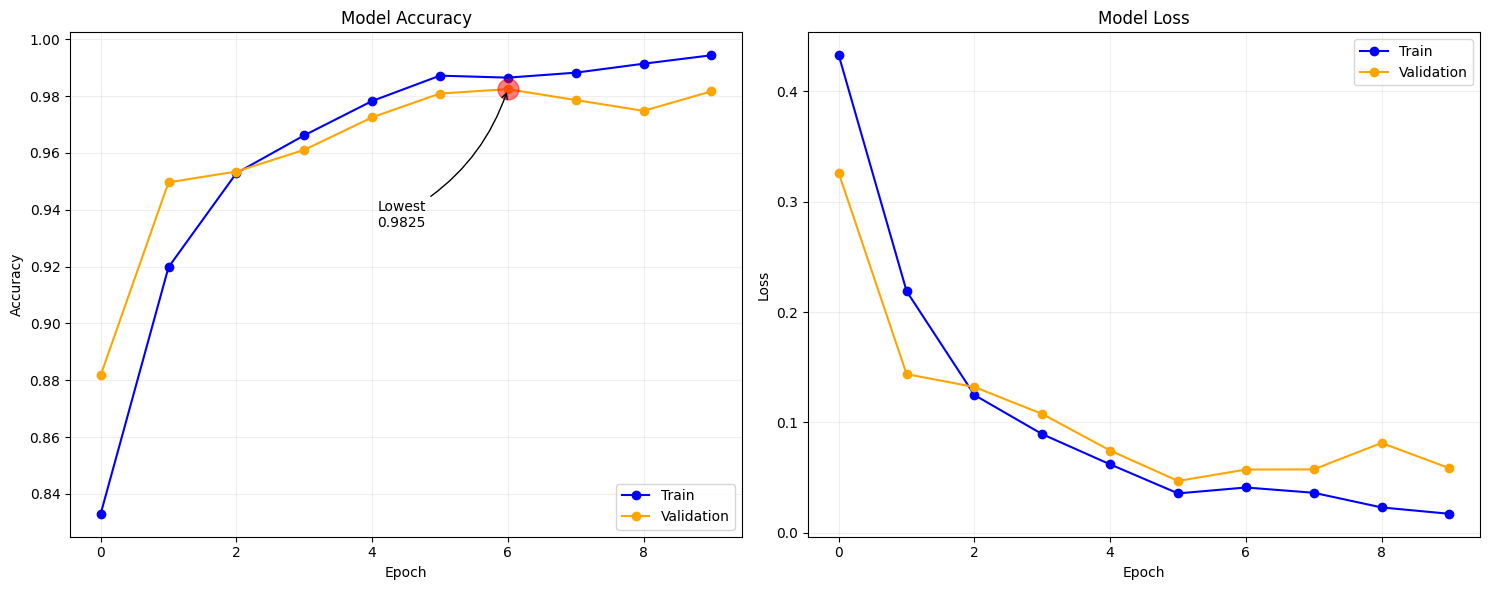

In [28]:
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
axes[0].plot(vgg16_history.history['accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(vgg16_history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
axes[1].plot(vgg16_history.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(vgg16_history.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(vgg16_history.history['val_accuracy'])
min_val_acc = np.max(vgg16_history.history['val_accuracy'])
axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [29]:
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
for images, labels in test_ds_preprocessed.unbatch():
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    pred = vgg16_model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

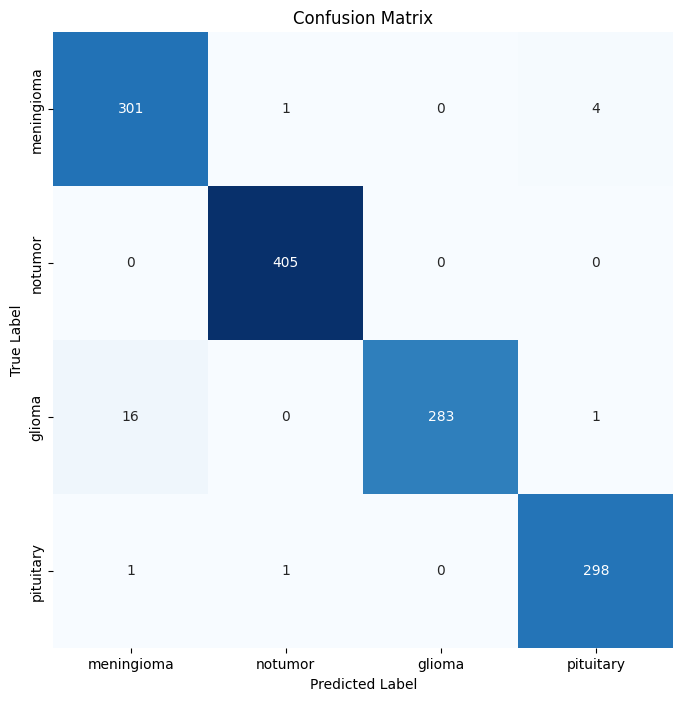

Class-wise metrics:
Class: meningioma
Precision: 0.9465
Recall: 0.9837
F1-Score: 0.9647

Class: notumor
Precision: 0.9951
Recall: 1.0000
F1-Score: 0.9975

Class: glioma
Precision: 1.0000
Recall: 0.9433
F1-Score: 0.9708

Class: pituitary
Precision: 0.9835
Recall: 0.9933
F1-Score: 0.9884

Overall Accuracy: 0.9817


In [30]:
# Plot confusion matrix for VGG16 Model
plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=True)

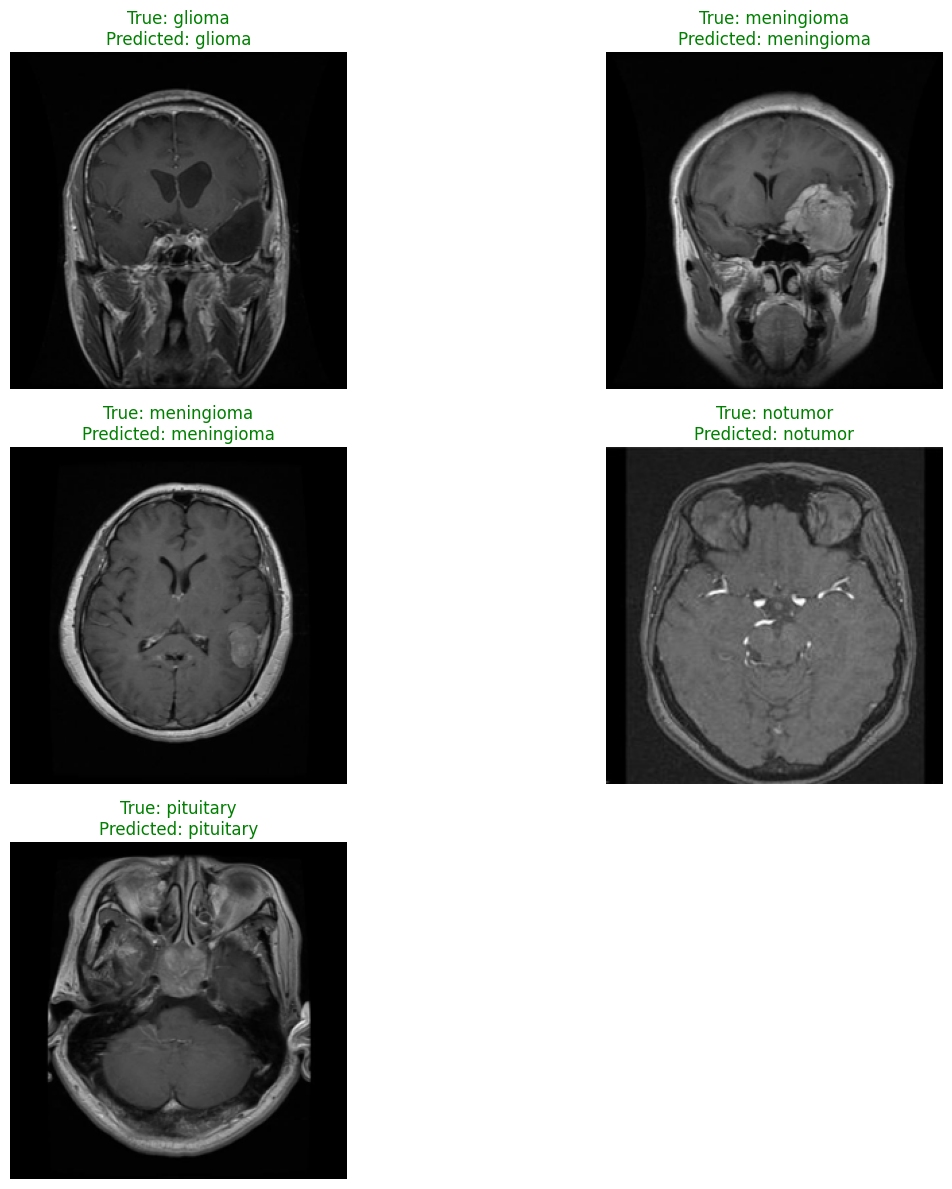

In [31]:
# Plot sample predictions for VGG16 Model
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
plot_sample_predictions(cnn_vgg16_model, prediction_folder, inv_class_naming, figsize=(13, 12))

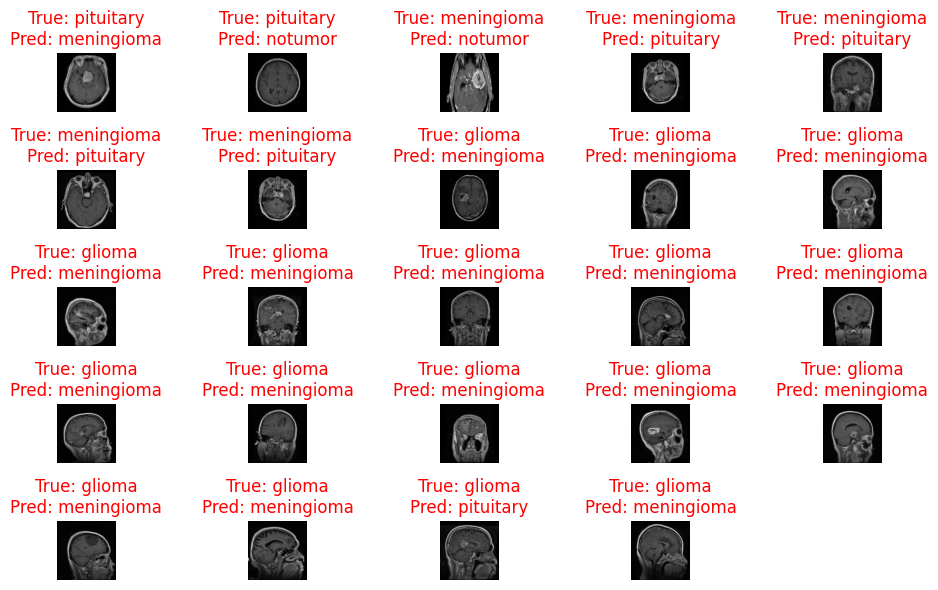

In [32]:
# Plotting samples with predictions
plot_misclassified_samples(model=vgg16_model, dataset=test_ds_preprocessed, indx_to_class=inv_class_naming, figsize=(10, 6))

**Model: KNN**

In [21]:
# Preprocess image for machine learning
def preprocess_image(img_path, img_size=(250, 250)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img).flatten() / 255.0  # Flatten the image and normalize
    return img_array

In [22]:
X_train = np.array([preprocess_image(img_path) for img_path in training_img_paths])
y_train = np.array(training_label_indx)

X_test = np.array([preprocess_image(img_path) for img_path in testing_image_paths])
y_test = np.array(testing_label_indx)

In [23]:
# Create and train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Save the model
joblib.dump(knn_model, 'knn_model.pkl')

y_pred_knn = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 84.74%


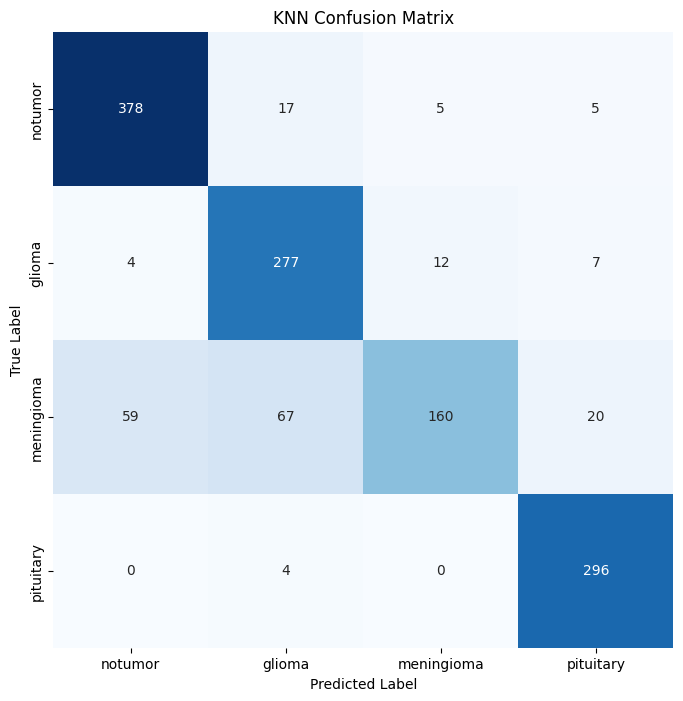

In [24]:
# #Display confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=class_naming.keys(), yticklabels=class_naming.keys())
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [25]:
# Function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


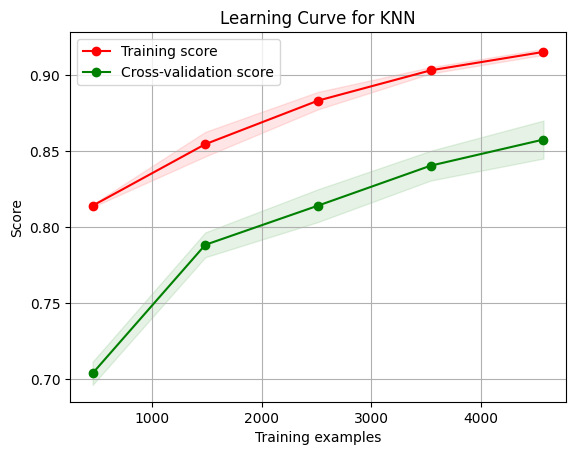

In [39]:
# Plot learning curve
plot_learning_curve(knn_model, "Learning Curve for KNN", X_train, y_train, cv=5)
plt.show()

In [26]:
# Function to predict the tumor type for a new image
def predict_tumor_type(img_array, model, class_naming):

    img_array = img_array.reshape(1, -1)
    prediction = model.predict(img_array)

    # Decode the prediction to get the tumor type
    inv_class_naming = {v: k for k, v in class_naming.items()}
    tumor_type = inv_class_naming[prediction[0]]
    return tumor_type

# Function to plot predictions for all images in the ImagePrediction folder
def plot_predictions(model, folder_path, class_naming, img_size=(250, 250), figsize=(13, 12)):
    image_paths = []
    true_labels = []

    # Collect image paths and corresponding labels
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_folder, img_file))
                    true_labels.append(class_name)

    num_samples = len(image_paths)
    rows = int(np.sqrt(num_samples))
    num_cols = (num_samples // rows) + (num_samples % rows > 0)

    plt.figure(figsize=figsize)

    for i in range(num_samples):
        img_path = image_paths[i]
        true_label = true_labels[i]
        img_array = preprocess_image(img_path, img_size=img_size)
        predicted_label = predict_tumor_type(img_array, model, class_naming)

        plt.subplot(rows, num_cols, i + 1)
        plt.imshow(img_array.reshape(img_size[0], img_size[1], 3))
        title_color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

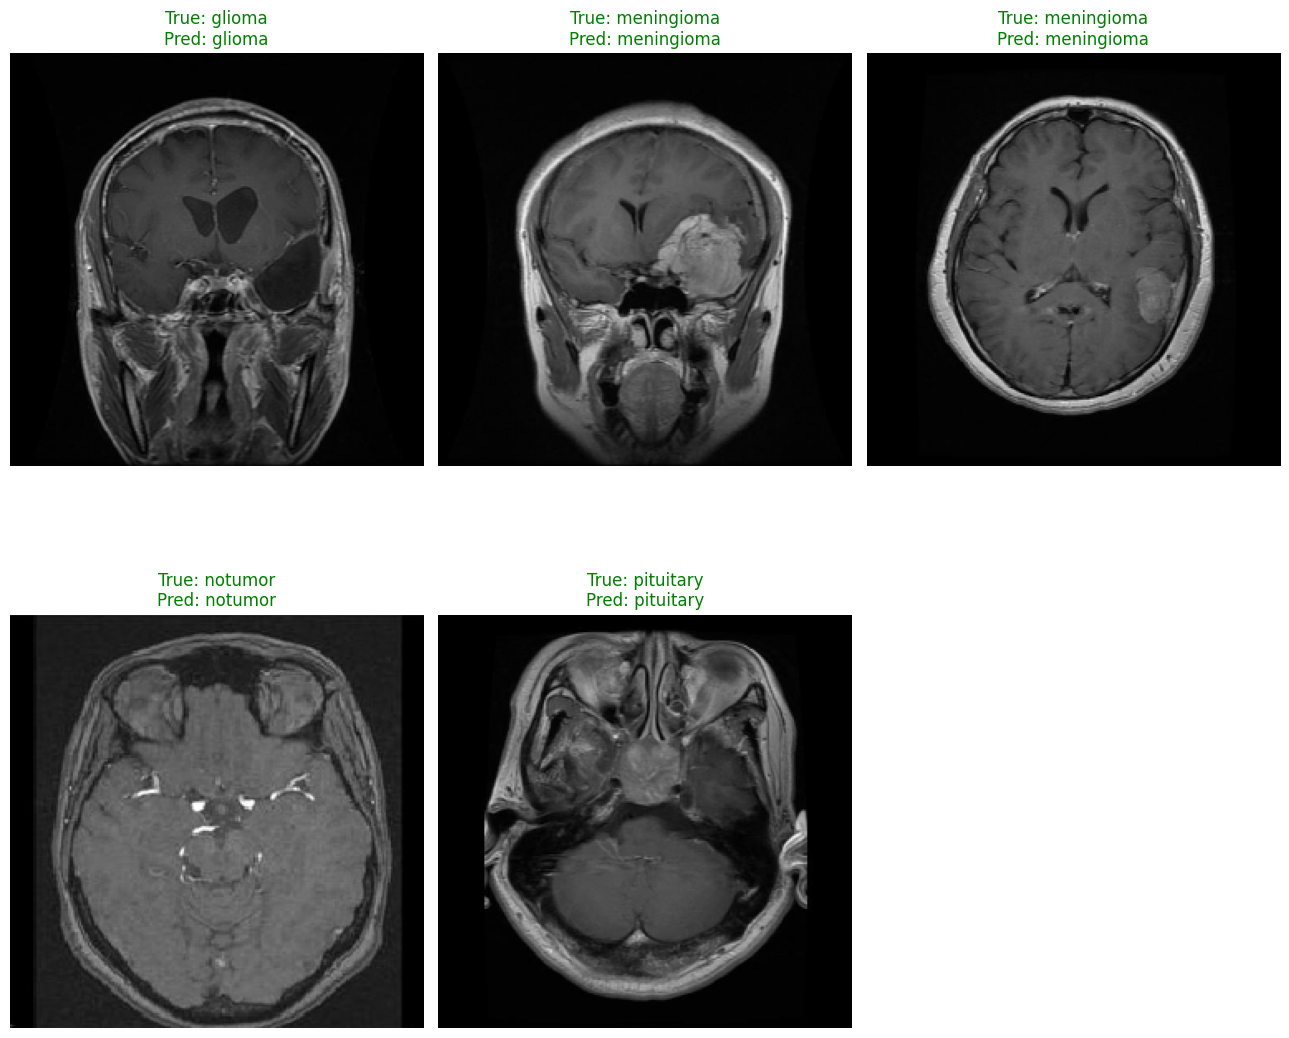

In [27]:
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
knn_model = joblib.load('knn_model.pkl')
plot_predictions(knn_model, prediction_folder, class_naming)

Model: RandomForest

In [ ]:
# # Preprocess all training images
# X_train_rf = np.array([preprocess_image(img_path) for img_path in training_img_paths])
# y_train_rf = np.array(training_label_indx)

# # Preprocess all testing images
# X_test_rf = np.array([preprocess_image(img_path) for img_path in testing_image_paths])
# y_test_rf = np.array(testing_label_indx)

In [28]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Save the model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [30]:
rf_model_file = joblib.load('random_forest_model.pkl')
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {accuracy_rf*100:.4f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_naming.keys()))

Random Forest Test Accuracy: 93.6690%
Classification Report:
              precision    recall  f1-score   support

     notumor       0.98      1.00      0.99       405
      glioma       0.97      0.85      0.90       300
  meningioma       0.85      0.91      0.88       306
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



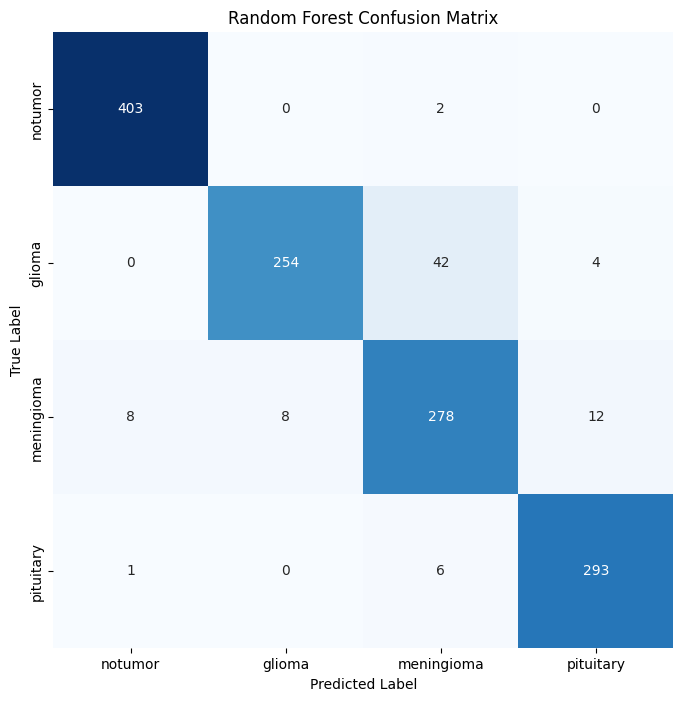

In [31]:
# Display confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 8))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=class_naming.keys(), yticklabels=class_naming.keys())
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [32]:
# Function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

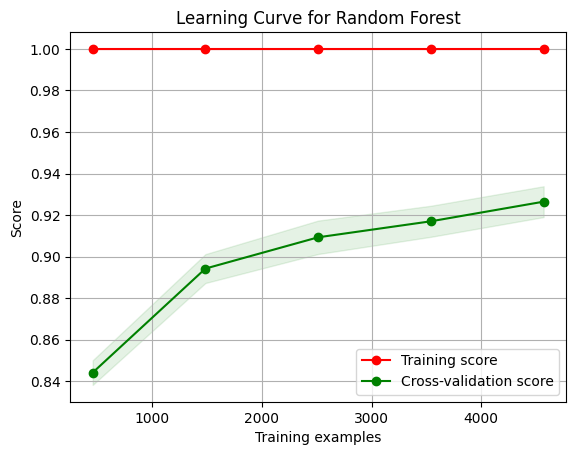

In [33]:
# Plot learning curve
plot_learning_curve(rf_model, "Learning Curve for Random Forest", X_train, y_train, cv=5)
plt.show()

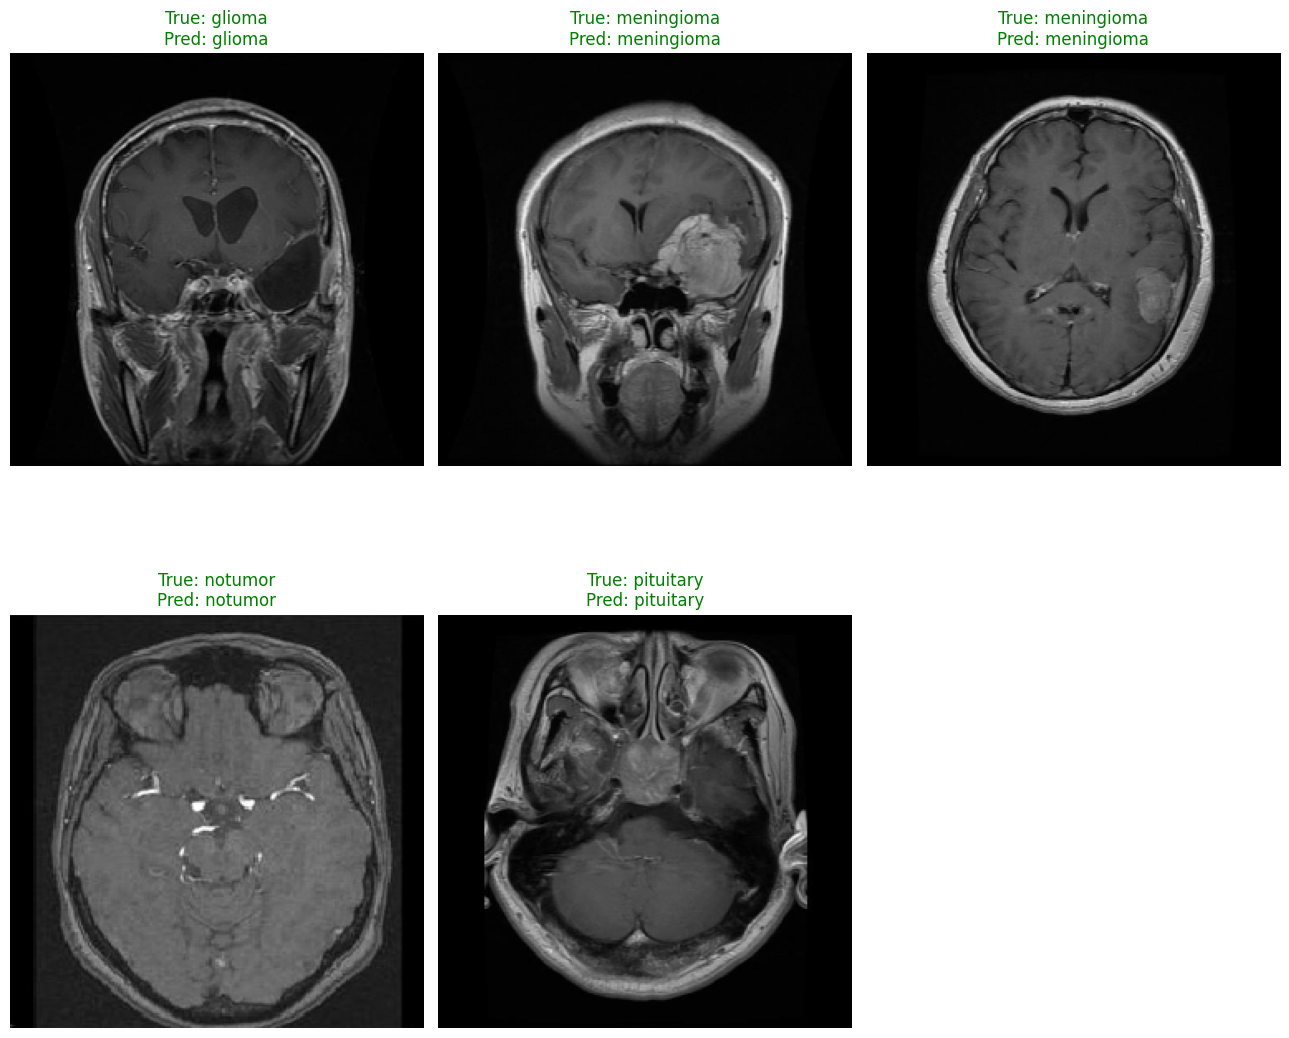

In [41]:
prediction_folder = '/content/drive/MyDrive/Final project/ImagePrediction'
rf_model = joblib.load('random_forest_model.pkl')
plot_predictions(rf_model, prediction_folder, class_naming)